In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

from scipy.sparse import csgraph
import scipy.sparse.linalg as sl

from collections import defaultdict
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
edges = pd.read_table('trust_data.txt', sep=' ').values[:-1, 1:3].astype(int)
edges = set([(a, b) for [a, b] in edges.tolist()])
edge_count = defaultdict(int)

for (a, b) in edges:
    edge_count[a] += 1
    edge_count[b] += 1
n = 2000
m = 3000
top_users = np.array(sorted([(a, b) for a, b in edge_count.items()], key=lambda x: -x[1])[:n])[:, 0].tolist()
rankings = pd.DataFrame(pd.read_table('ratings_data.txt', sep=' ').values[:-1, :3].astype(int), columns=['user', 'film', 'rating'])
top_films = rankings[rankings['user'].isin(top_users)].groupby('film').size().sort_values(ascending=False)[:m].index.tolist()
rankings = rankings[(rankings['film'].isin(top_films)) & (rankings['user'].isin(top_users))]
rankings[['user', 'film']] -= 1
dict_user = {a: i for i, a in enumerate(set(rankings['user']))}
dict_film = {a: i for i, a in enumerate(set(rankings['film']))}
rankings['user'] = rankings['user'].apply(lambda x: dict_user[x])
rankings['film'] = rankings['film'].apply(lambda x: dict_film[x])
sp_rankings = sparse.csr_matrix((rankings['rating'], (rankings['user'], rankings['film'])))

top_edges = []
for a, b in edges:
    if a-1 in dict_user and b-1 in dict_user:
        top_edges.append([a-1, b-1])
        top_edges.append([b-1, a-1])
top_edges = pd.DataFrame(top_edges, columns=['r', 'c'])
top_edges = top_edges.applymap(lambda x: dict_user[x])
sp_edges = sparse.csr_matrix((np.ones(top_edges.shape[0]), (top_edges['r'], top_edges['c'])))

L = csgraph.laplacian(sp_edges)

In [3]:
def sparse_pinv(A):
    return sl.inv(A.T@A)@A.T

def get_RMSE(A,A_):
    A1d = np.ravel(A)
    A_1d = np.ravel(A_)
    e = np.mean((A1d-A_1d)**2)
    return np.sqrt(e)

def kpmf(R, L, D=10, iters=100, l=0.001, ker='reg', beta=5, gamma = 0.1, eps = 0.01):
    N = R.shape[0]
    M = R.shape[1]
    U = np.random.randn(N,D)
    V = np.random.randn(M,D)
    sigma = 1
    sigma_v = 1
    KV = sigma_v*sparse.eye(M).tocsr()
    if ker == 'dif':
#     diffusion
        KU = sl.expm(-beta*L)
        SU = sparse_pinv(KU)
    else:
#     regularized laplacian
        SU = sparse.eye(N).tocsr() + gamma*L
    SV = KV
    coef = -2/(sigma**2)
#     rmse = []
    errs = []
    for k in tqdm(range(iters)):
        for n in range(N):
            for m in range(M):
                if R[n,m]!=0:
                    nonzero_n = 1/len(R[n,:].nonzero()[0])
                    nonzero_m = 1/len(R[:,m].nonzero()[0])
                    su = np.zeros_like(U[0,:])
                    sv = np.zeros_like(V[0,:])
                    for r in range(N):
                        su += SU[n,r]*U[r,:] 
                    for r in range(M):
                        sv += SV[m,r]*V[r,:]
                    grad_U = coef*(R[n,m]-np.dot(U[n,:],V[m,:].T))*V[m,:] + \
                         nonzero_n*(su + SU[n,n]*U[n,:])
                    grad_V = coef*(R[n,m]-np.dot(U[n,:],V[m,:].T))*U[n,:] + \
                         nonzero_m*(sv + SV[m,m]*V[m,:])
                    U[n,:] -= l*(grad_U)
                    V[m,:] -= l*(grad_V)
        A_new = np.dot(U,V.T)
#         rmse.append(get_RMSE(R.todense(),A_new))
#         print (rmse)
        if k>0:
            err = np.linalg.norm(A - A_new,'fro')/np.linalg.norm(A_new,'fro')
#             print(err)
            errs.append(err)
            if err <= eps:
                break
        A = A_new
    return A, errs

Text(0,0.5,'Relative Error')

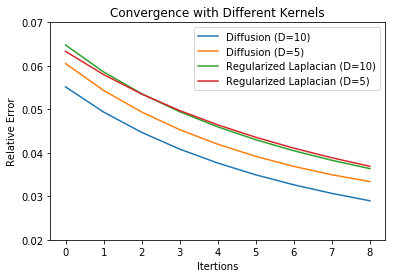

In [57]:
plt.plot(range(10-1),ERR_dif[1],label = 'Diffusion (D=10)')
plt.plot(range(10-1),ERR_dif_5[1],label = 'Diffusion (D=5)')
plt.plot(range(10-1),ERR_reg[1],label = 'Regularized Laplacian (D=10)')
plt.plot(range(10-1),ERR_reg_5[1],label = 'Regularized Laplacian (D=5)')

plt.legend()
plt.ylim([0.02,0.07])
plt.title('Convergence with Different Kernels')
plt.xlabel('Itertions')
plt.ylabel('Relative Error')

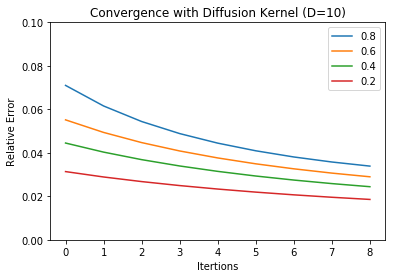

In [58]:
lab = ['0.8','0.6','0.4','0.2']
for c in range(len(ERR_dif)):
    plt.plot(range(10-1),ERR_dif[c],label = lab[c])
    plt.legend()
    plt.ylim([0,0.1])
    plt.title('Convergence with Diffusion Kernel (D=10)')
    plt.xlabel('Itertions')
    plt.ylabel('Relative Error')

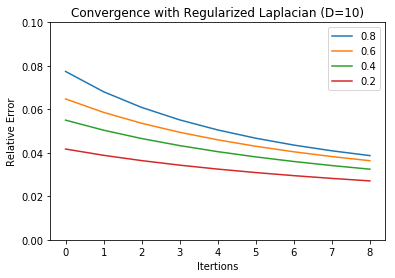

In [59]:
lab = ['0.8','0.6','0.4','0.2']
for c in range(len(ERR_reg)):
    plt.plot(range(10-1),ERR_reg[c],label = lab[c])
    plt.legend()
    plt.ylim([0,0.1])
    plt.title('Convergence with Regularized Laplacian (D=10)')
    plt.xlabel('Itertions')
    plt.ylabel('Relative Error')

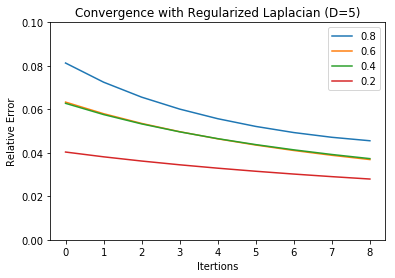

In [61]:
lab = ['0.8','0.6','0.4','0.2']
for c in range(len(ERR_reg_5)):
    plt.plot(range(10-1),ERR_reg_5[c],label = lab[c])
    plt.legend()
    plt.ylim([0,0.1])
    plt.title('Convergence with Regularized Laplacian (D=5)')
    plt.xlabel('Itertions')
    plt.ylabel('Relative Error')

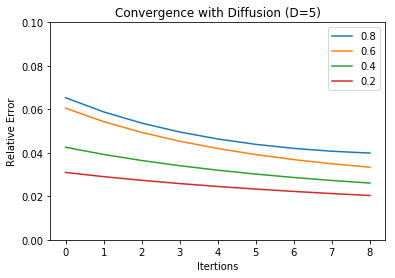

In [62]:
lab = ['0.8','0.6','0.4','0.2']
for c in range(len(ERR_dif_5)):
    plt.plot(range(10-1),ERR_dif_5[c],label = lab[c])
    plt.legend()
    plt.ylim([0,0.1])
    plt.title('Convergence with Diffusion (D=5)')
    plt.xlabel('Itertions')
    plt.ylabel('Relative Error')

In [6]:
KPMF_dif_RMSE = []
KPMF_reg_RMSE = []
ERR_dif = []
ERR_reg = []
X_full = sp_rankings.todense()
origA = X_full.copy()

sparseness = [0.2,0.4,0.6,0.8]
for spar in sparseness:
    A_sp = X_full.copy()
    for i in range(A_sp.shape[0]):
        for j in range(A_sp.shape[1]):
            if np.random.rand() < spar:
                A_sp[i,j] = 0.
            
    A_,errs=kpmf(A_sp, L, D=10, iters=10, l=0.001, ker='dif', beta=0.01, gamma=0.1, eps = 0.001)
    RMSE = get_RMSE(origA, A_)
    ERR_dif.append(errs)
    print(spar, RMSE)
    KPMF_dif_RMSE.append(RMSE)
    
    A_,errs= kpmf(A_sp, L, D=10, iters=10, l=0.001, ker='reg', beta=0.01, gamma=0.1, eps = 0.001)
    RMSE = get_RMSE(origA, A_)
    ERR_reg.append(errs)
    print( RMSE)
    KPMF_reg_RMSE.append(RMSE)   

/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
  0%|          | 0/10 [00:00<?, ?it/s]

0.2 2.7105732605377306


100%|██████████| 10/10 [11:12<00:00, 67.16s/it]


2.373000157349065


  0%|          | 0/10 [00:00<?, ?it/s]

0.4 2.795510098622622


100%|██████████| 10/10 [08:26<00:00, 50.72s/it]


2.3917734241200015


  0%|          | 0/10 [00:00<?, ?it/s]

0.6 2.8328561355389597


100%|██████████| 10/10 [05:26<00:00, 32.62s/it]


2.559985019237379


  0%|          | 0/10 [00:00<?, ?it/s]

0.8 3.0391168365575183


100%|██████████| 10/10 [02:47<00:00, 16.76s/it]

2.812670781580357


(1, 2.2)

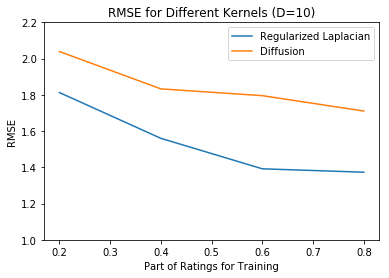

In [68]:
plt.plot(1-np.arange(0.2,1,0.2),np.array(KPMF_reg_RMSE),label='Regularized Laplacian');
plt.plot(1-np.arange(0.2,1,0.2),np.array(KPMF_dif_RMSE), label='Diffusion')
plt.legend()
plt.title('RMSE for Different Kernels (D=10)')
plt.ylabel('RMSE')
plt.xlabel('Part of Ratings for Training');
plt.ylim([1,2.2])
# KPMF_reg_RMSE

In [12]:
KPMF_dif_RMSE_5 = []
KPMF_reg_RMSE_5 = []
ERR_dif_5 = []
ERR_reg_5 = []
X_full = sp_rankings.todense()
origA = X_full.copy()

sparseness = [0.2,0.4,0.6,0.8]
for spar in sparseness:
    A_sp = X_full.copy()
    for i in range(A_sp.shape[0]):
        for j in range(A_sp.shape[1]):
            if np.random.rand() < spar:
                A_sp[i,j] = 0.
            
    A_,errs=kpmf(A_sp, L, D=5, iters=10, l=0.001, ker='dif', beta=0.01, gamma=0.1, eps = 0.001)
    RMSE = get_RMSE(origA, A_)
    ERR_dif_5.append(errs)
    print(spar, RMSE)
    KPMF_dif_RMSE_5.append(RMSE)
    
    A_,errs= kpmf(A_sp, L, D=5, iters=10, l=0.001, ker='reg', beta=0.01, gamma=0.1, eps = 0.001)
    RMSE = get_RMSE(origA, A_)
    ERR_reg_5.append(errs)
    print( RMSE)
    KPMF_reg_RMSE_5.append(RMSE)   

/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
  0%|          | 0/10 [00:00<?, ?it/s]

0.2 1.9726504146315602


100%|██████████| 10/10 [11:33<00:00, 69.40s/it]


1.7665205527756886


  0%|          | 0/10 [00:00<?, ?it/s]

0.4 1.9834813776461335


100%|██████████| 10/10 [08:27<00:00, 50.75s/it]


1.8543224025039957


  0%|          | 0/10 [00:00<?, ?it/s]

0.6 2.1345494410941126


100%|██████████| 10/10 [05:52<00:00, 35.26s/it]


1.876263945700042


  0%|          | 0/10 [00:00<?, ?it/s]

0.8 2.2838847150631967


100%|██████████| 10/10 [02:46<00:00, 16.65s/it]

2.0538716482722696


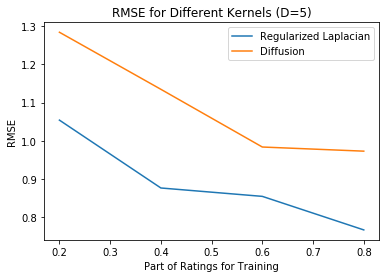

In [72]:
plt.plot(1-np.arange(0.2,1,0.2),np.array(KPMF_reg_RMSE_5),label='Regularized Laplacian');
plt.plot(1-np.arange(0.2,1,0.2),np.array(KPMF_dif_RMSE_5),label='Diffusion')
plt.legend()
plt.title('RMSE for Different Kernels (D=5)')
plt.ylabel('RMSE')
plt.xlabel('Part of Ratings for Training');
# plt.ylim([0.5,2.2]);
# KPMF_reg_RMSE

In [ ]:
%%time
A,rmse = kpmf(sp_rankings, L, iters=20)


  5%|▌         | 1/20 [01:28<28:07, 88.81s/it]

[3.078978065526198]



 10%|█         | 2/20 [02:57<26:39, 88.88s/it]

[3.078978065526198, 2.8991951908025255]
0.08792700122851993



 15%|█▌        | 3/20 [04:27<25:12, 88.97s/it]

[3.078978065526198, 2.8991951908025255, 2.7546960273693393]
0.07713086985096457


In [126]:
%%time
A, rmse = kpmf(sp_rankings, L, iters=10)




  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:16<02:32, 16.95s/it]

[3.262598311051897]





 20%|██        | 2/10 [00:33<02:15, 16.97s/it]

[3.262598311051897, 3.096211315220747]
0.07915937615464227





 30%|███       | 3/10 [00:50<01:58, 16.98s/it]

[3.262598311051897, 3.096211315220747, 2.9602608467724654]
0.06994256396558418





 40%|████      | 4/10 [01:07<01:41, 16.98s/it]

[3.262598311051897, 3.096211315220747, 2.9602608467724654, 2.846999195257868]
0.06276040378796459





 50%|█████     | 5/10 [01:24<01:24, 16.98s/it]

[3.262598311051897, 3.096211315220747, 2.9602608467724654, 2.846999195257868, 2.751185886899577]
0.05703297839236796





 60%|██████    | 6/10 [01:41<01:07, 16.98s/it]

[3.262598311051897, 3.096211315220747, 2.9602608467724654, 2.846999195257868, 2.751185886899577, 2.669128779811012]
0.0523969506070584


KeyboardInterrupt: 